In [10]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras import callbacks
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [11]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train[:20%]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


In [12]:
#IMG_SIZE = 224

#ds_train = ds_train.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))
#ds_test = ds_test.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))

In [13]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
#ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(32)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)


In [14]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(32)
#ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)


In [15]:
'''
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.
'''
base_model = keras.applications.ResNet50V2(
    weights="imagenet",
    input_shape=(128,128,3),
    include_top=False
)

In [16]:
data_augmentation = keras.Sequential(
                [layers.RandomFlip('horizontal'), 
                layers.RandomRotation(factor=(-0.025, 0.025)),
                layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
                layers.RandomContrast(factor=0.1),
                ])

In [17]:
'''
for image, label in ds_train.take(1): # Iterate and get set of image and label from train_ds generator
    plt.figure(figsize=(10, 10))
    for i in range(4):  # Display augmented images in 2x2 grid
        ax = plt.subplot(2, 2, i+1)
        aug_img = data_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype('uint8')) # Retrieve raw pixel value
        plt.title(get_label_name(int(label[0]))) # Get corresponding label
        plt.axis('off')
'''

"\nfor image, label in ds_train.take(1): # Iterate and get set of image and label from train_ds generator\n    plt.figure(figsize=(10, 10))\n    for i in range(4):  # Display augmented images in 2x2 grid\n        ax = plt.subplot(2, 2, i+1)\n        aug_img = data_augmentation(tf.expand_dims(image, axis=0))\n        plt.imshow(aug_img[0].numpy().astype('uint8')) # Retrieve raw pixel value\n        plt.title(get_label_name(int(label[0]))) # Get corresponding label\n        plt.axis('off')\n"

In [18]:
#sequential 
inputs = keras.Input(shape=(32, 32, 3))
model = tf.keras.models.Sequential()
model.add(keras.layers.RandomFlip('horizontal'))
model.add(keras.layers.RandomRotation(factor=(-0.025, 0.025)))
model.add(keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1))
model.add(keras.layers.RandomContrast(factor=0.1))
model.add(tf.keras.layers.UpSampling2D((2,2)))
model.add(tf.keras.layers.UpSampling2D((2,2)))
#model.add(keras.applications.resnet_v2.preprocess_input())
#model.add(tf.keras.layers.UpSampling2D((2,2)))
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())

model.add(tf.keras.layers.Dense(128, activation='relu'))
#model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(10,activation='softmax'))
  
  


In [19]:
#Traditional Training
#model = tf.keras.models.Sequential([
#  tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
#  tf.keras.layers.Dense(128, activation='relu'),
#  tf.keras.layers.Dense(10)
#])
earlystopping = callbacks.EarlyStopping(monitor='val_loss', 
                                        mode='min', 
                                        patience=5, 
                                        restore_best_weights=True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')],
)

model.fit(
    ds_train,
    epochs=5,
    #batch_size=512,
    validation_data=ds_test,
    callbacks =[earlystopping],
)


Epoch 1/5


313/313 [==============================] - 241s 662ms/step - loss: 1.6675 - accuracy: 0.4380 - val_loss: 1.4694 - val_accuracy: 0.5200
Epoch 2/5
313/313 [==============================] - 150s 471ms/step - loss: 1.1306 - accuracy: 0.6192 - val_loss: 1.8900 - val_accuracy: 0.5435
Epoch 3/5
313/313 [==============================] - 124s 397ms/step - loss: 0.9054 - accuracy: 0.6913 - val_loss: 1.2436 - val_accuracy: 0.5906
Epoch 4/5
313/313 [==============================] - 166s 521ms/step - loss: 0.8320 - accuracy: 0.7127 - val_loss: 1.1937 - val_accuracy: 0.6369
Epoch 5/5
313/313 [==============================] - 142s 454ms/step - loss: 0.7110 - accuracy: 0.7561 - val_loss: 0.9542 - val_accuracy: 0.6980


In [20]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')],
)
testing = model.fit(
    ds_train,
    epochs=11,
    #batch_size=512,
    validation_data=ds_test,
    verbose=1,
    callbacks =[earlystopping],
)



Epoch 1/11


/home/sjhjrok/anaconda3/envs/ai/lib/python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


313/313 [==============================] - 166s 497ms/step - loss: 0.6992 - accuracy: 0.7648 - val_loss: 0.6433 - val_accuracy: 0.7828
Epoch 2/11
313/313 [==============================] - 143s 456ms/step - loss: 0.6090 - accuracy: 0.7926 - val_loss: 0.6101 - val_accuracy: 0.7924
Epoch 3/11
313/313 [==============================] - 151s 473ms/step - loss: 0.5799 - accuracy: 0.8017 - val_loss: 0.5893 - val_accuracy: 0.8009
Epoch 4/11
313/313 [==============================] - 151s 481ms/step - loss: 0.5393 - accuracy: 0.8223 - val_loss: 0.5738 - val_accuracy: 0.8063
Epoch 5/11
313/313 [==============================] - 145s 453ms/step - loss: 0.5270 - accuracy: 0.8187 - val_loss: 0.5631 - val_accuracy: 0.8096
Epoch 6/11
313/313 [==============================] - 171s 546ms/step - loss: 0.4948 - accuracy: 0.8322 - val_loss: 0.5521 - val_accuracy: 0.8151
Epoch 7/11
313/313 [==============================] - 161s 496ms/step - loss: 0.4809 - accuracy: 0.8349 - val_loss: 0.5305 - val_accura

<function matplotlib.pyplot.show(close=None, block=None)>

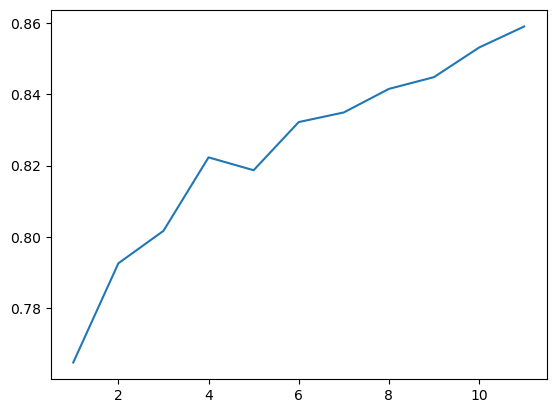

In [21]:

plt.plot(
    np.arange(1, 12), 
    testing.history['accuracy'], label='Accuracy'
)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

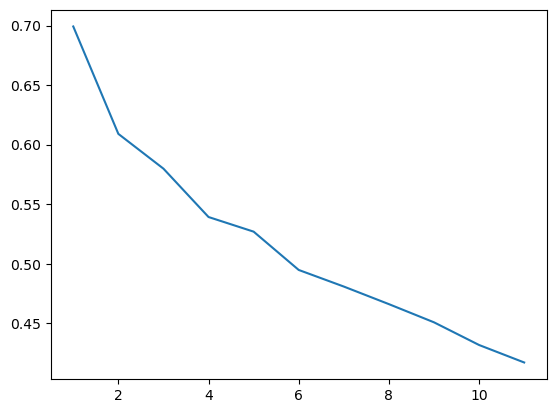

In [22]:
plt.plot(
    np.arange(1, 12), 
    testing.history['loss'], label='Loss'
)
plt.show

In [23]:
model.evaluate(ds_test)


313/313 [==============================] - 9s 29ms/step - loss: 0.5156 - accuracy: 0.8282


[0.5155838131904602, 0.8281999826431274]